# Optimizing warehouse flows using Q-learning

## Imports

In [0]:
import random
from collections import defaultdict, namedtuple
from itertools import product, starmap

import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from scipy import stats
%matplotlib inline
sns.set()
states_colors = matplotlib.colors.ListedColormap(['#9A9A9A', '#D886BA', '#4D314A', '#6E9183'])
cmap_default = 'Blues'
cpal_default = sns.color_palette(('Blues_d'))

sns.set_style('white')
sns.set_context('poster')
random.seed(1)

### Q-learning parametes

In [0]:
gamma = 0.75
alpha = 0.9

## Problem statement

In a warehouse setting, our goal is to optimize the routes followed by an order pickup robot that was to collect containers from 12 different sections (labeled from A to L). Each section has a priority rank and those with higher ranks should be visited first.

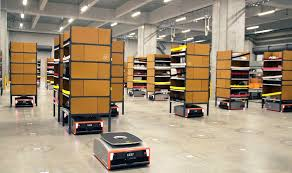

| Priority Rank | Location   |
|---------------|------------|
|       1       |     G      |
|       2       |     K      |
|       3       |     L      |
|       4       |     J      |
|       5       |     A      |
|       6       |     I      |
|       7       |     H      |
|       8       |     C      |
|       9       |     B      |
|      10       |     D      |
|      11       |     F      |
|      12       |     E      |

Location G has priority 1, which means it is the top priority, as it contains a product that must be collected
and delivered immediately. Our Autonomous Warehouse Robot must move to location G by the shortest
route depending on where it is. Our goal is to build an AI that will return that shortest route, wherever the
robot is. But then as we see, locations K and L are in the Top 3 priorities. Hence we will want to implement
an option for our Autonomous Warehouse Robot to go by some intermediary locations before reaching its
final top priority location.

The way the system computes the priorities of the locations is out of the scope of this case study. The reason
for this is that there can be many ways, from simple rules or algorithms, to deterministic computations, to
machine learning. But most of these ways would not be artificial intelligence as we know it today. What
we really want to focus on is core AI, encompassing Q-Learning, Deep Q-Learning and other branches of
Reinforcement Learning. So we will just say for example that Location G is top priority because one of the
most loyal platinum customers of the company placed an urgent order of a product stored in location G
which therefore must be delivered as soon as possible.

Therefore in conclusion, our mission is to build an AI that will always take the shortest route to the top
priority location, whatever the location it starts from, and having the option to go by an intermediary
location which is in the top 3 priorities.

## Environment definition



### States

Let’s start with the states. The input state is simply the location where our Autonomous Warehouse Robot
is at each time t. However since we will build our AI with mathematical equations, we will encode the
locations names (A, B, C,...) into index numbers, with respect to the following mapping:

| Location | State |
|----------|-------|
|    A     |   0   |
|    B     |   1   |
|    C     |   2   |
|    D     |   3   |
|    E     |   4   |
|    F     |   5   |
|    G     |   6   |
|    H     |   7   |
|    I     |   8   |
|    J     |   9   |
|    K     |   10  |
|    L     |   11  |

In [0]:
location_to_state = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6,
    'H': 7,
    'I': 8,
    'J': 9,
    'K': 10,
    'L': 11
}

### Actions

Now let’s define the possible actions to play. The actions are simply the next moves the robot can make to
go from one location to the next. So for example, let’s say the robot is in location J, the possible actions that
the robot can play is to go to I, to F, or to K. And again, since we will work with mathematical equations,
we will encode these actions with the same indexes as for the states. Hence, following our same example
where the robot is in location J at a specific time, the possible actions that the robot can play are, according
to our previous mapping above: 5, 8 and 10. Indeed, the index 5 corresponds to F, the index 8 corresponds
to I, and the index 10 corresponds to K. Therefore eventually, the total list of actions that the AI can play
overall is the following:

In [0]:
actions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

### Rewards


In [0]:
R = np.array([
  [0,1,0,0,0,0,0,0,0,0,0,0],
  [1,0,1,0,0,1,0,0,0,0,0,0],
  [0,1,0,0,0,0,1,0,0,0,0,0],
  [0,0,0,0,0,0,0,1,0,0,0,0],
  [0,0,0,0,0,0,0,0,1,0,0,0],
  [0,1,0,0,0,0,0,0,0,1,0,0],
  [0,0,1,0,0,0,1000,1,0,0,0,0],
  [0,0,0,1,0,0,1,0,0,0,0,1],
  [0,0,0,0,1,0,0,0,0,1,0,0],
  [0,0,0,0,0,1,0,0,1,0,1,0],
  [0,0,0,0,0,0,0,0,0,1,0,1],
  [0,0,0,0,0,0,0,1,0,0,1,0]
])

### Building Solution

### Initializing Q-values

For all couples of states $s$ and actions $a$, the Q-Values are initialized to 0:

\begin{align*}
∀s ∈ S, a ∈ A, Q_0(s, a) = 0
\end{align*}

We start in the initial state $s_0$. We play a random possible action and we reach the first state $s_1$.

Then for each $t ≥ 1$, we will repeat for a certain number of times (1000 times in our code) the following:
1. We select a random state s t from our 12 possible states:
\begin{align*}
s_t = random(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)
\end{align*}

2. We play a random action a $t$ that can lead to a next possible state, i.e., such that $R(s_t , a_t ) > 0$:
\begin{align*}
a_t = random(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11) \rightarrow R(s_t , a_t ) > 0
\end{align*}

3. We reach the **next state** $s_{t+1}$ and we get the reward $R(s_t , a_t )$

4. We compute the **Temporal Difference (TD)**: 
\begin{align*}
TD_t (s_t , a_t ) = R(s_t , a_t) + γ \:\max_{a} (Q(s_{t+1}, a)) − Q(s_t , a_t)
\end{align*}

5. We update the Q-value by applying the Bellman equation:
\begin{align*}
Q_t (s_t , a_t ) = Q_{t−1} (s_t , a_t ) + α\:TD_t (s_t , a_t )
\end{align*}


In [0]:
Q = np.array(np.zeros([12, 12]))

for t in range(0,1000):
  current_state = np.random.randint(0, 12)
  playable_actions = np.where(R[current_state] > 0)[0]
  next_state = np.random.choice(playable_actions)
  TD = R[current_state, next_state] + gamma * np.max(Q[next_state, :]) - Q[current_state, next_state]
  Q[current_state, next_state] += alpha * TD


## Find optimal route

The **route** function takes as inputs the starting and ending locations, and returns the optimal path
between these two locations. To explain exactly what this function does, let’s enumerate the different
steps of the process, when going from location E to location G:
1. We start at our starting location E.
2. We get the state of location E, which according to our location_to_state mapping is s 0 = 4.
3. On the row of index s 0 = 4 in our matrix of Q-Values, we find the column that has the maximum
Q-Value (703).
4. This column has index 8, so we play the action of index 8 which leads us to the next state s t+1 = 8.
5. We get the location of state 8, which according to our state_to_location mapping is location I. Hence
our next location is location I, which is appended to our list containing the optimal path.
6. We repeat the same previous 5-steps from our new starting location I, until we reach our final desti-
nation, location G.

In [68]:
Q.astype(int)

array([[   0, 1683,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [1254,    0, 2246,    0,    0, 1260,    0,    0,    0,    0,    0,
           0],
       [   0, 1683,    0,    0,    0,    0, 2994,    0,    0,    0,    0,
           0],
       [   0,    0,    0,    0,    0,    0,    0, 2245,    0,    0,    0,
           0],
       [   0,    0,    0,    0,    0,    0,    0,    0,  710,    0,    0,
           0],
       [   0, 1682,    0,    0,    0,    0,    0,    0,    0,  946,    0,
           0],
       [   0,    0, 2246,    0,    0,    0, 3991, 2245,    0,    0,    0,
           0],
       [   0,    0,    0, 1681,    0,    0, 2993,    0,    0,    0,    0,
        1681],
       [   0,    0,    0,    0,  533,    0,    0,    0,    0,  946,    0,
           0],
       [   0,    0,    0,    0,    0, 1260,    0,    0,  710,    0, 1260,
           0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,  946,    0,
        1684],
       [   0,    0,  